# Column generation approach

## Pre-requisites

In [1]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

from src import cg, config, dataset, layers, pack, superitems, utils, warm_start

In [2]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Dataset

In [4]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

In [6]:
ordered_products = 100
order = product_dataset.get_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,269114,177,162,298,21,8544852
1,334618,220,213,312,14,14620320
2,832972,273,228,405,2,25208820
3,151456,271,167,350,4,15839950
4,804449,251,181,349,2,15855419


<IPython.core.display.Javascript object>

In [6]:
order = pd.concat([order.sample(4)] * 5).reset_index(drop=True)
order.head()

,id,width,depth,height,weight,volume
0,121958,193,221,371,2,15824263
1,671155,236,142,437,58,14644744
2,54886,249,142,388,3,13718904
3,644167,286,158,481,6,21735428
4,121958,193,221,371,2,15824263


<IPython.core.display.Javascript object>

In [18]:
order = order.sample(100).reset_index(drop=True)
order["height"] = 400
order.head()

ValueError: Cannot take a larger sample than population when 'replace=False'

<IPython.core.display.Javascript object>

## Martello's lower bounds

In [125]:
utils.get_l0_lb(order, config.PALLET_DIMS)

9.0

<IPython.core.display.Javascript object>

In [126]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [10]:
utils.get_l2_lb(order, config.PALLET_DIMS)

TypeError: get_l1_lb() takes 2 positional arguments but 4 were given

<IPython.core.display.Javascript object>

## Superitems

In [97]:
superitems_pool = superitems.SuperitemPool(
    order=order, pallet_dims=config.PALLET_DIMS, max_vstacked=4, not_horizontal=True
)
superitems_pool.to_dataframe()

Generating vertical superitems: 100%|██████████| 28/28 [00:00<00:00, 355880.34it/s]


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,241,158,342,[1],SingleItemSuperitem
2,268,313,456,[2],SingleItemSuperitem
3,231,176,329,[3],SingleItemSuperitem
4,363,151,487,[4],SingleItemSuperitem
...,...,...,...,...,...
200,169,251,922,"[11, 12, 67, 77]",VerticalSuperitem
201,196,304,1240,"[40, 74, 79, 84]",VerticalSuperitem
202,226,282,1281,"[13, 38, 44, 95]",VerticalSuperitem
203,237,378,1518,"[14, 18, 41, 69]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [37]:
df = superitems_pool.to_dataframe()
df[df["type"].str.contains("Vertical")]

,width,depth,height,ids,type
100,151,141,516,"[49, 73]",VerticalSuperitem
101,160,111,525,"[16, 75]",VerticalSuperitem
102,176,155,503,"[55, 65]",VerticalSuperitem
103,177,175,537,"[78, 91]",VerticalSuperitem
104,178,174,421,"[15, 24]",VerticalSuperitem
...,...,...,...,...,...
201,196,242,1053,"[11, 74, 77, 89]",VerticalSuperitem
202,222,269,1222,"[44, 67, 79, 95]",VerticalSuperitem
203,237,291,1306,"[13, 38, 69, 84]",VerticalSuperitem
204,268,318,1589,"[2, 23, 40, 41]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [9]:
df = superitems_pool.to_dataframe()
df[df["type"].str.contains("Horizontal")]

,width,depth,height,ids,type


<IPython.core.display.Javascript object>

## Height groups

In [99]:
height_groups = warm_start.get_height_groups(
    superitems_pool, config.PALLET_DIMS, height_tol=50, density_tol=0.0
)
for group in height_groups:
    display(group.to_dataframe())

,width,depth,height,ids,type
0,155,205,176,[11],SingleItemSuperitem
1,110,183,139,[98],SingleItemSuperitem


,width,depth,height,ids,type
0,155,205,176,[11],SingleItemSuperitem
1,168,173,224,[12],SingleItemSuperitem
2,178,83,195,[15],SingleItemSuperitem
3,177,174,226,[24],SingleItemSuperitem
4,192,132,201,[34],SingleItemSuperitem
5,179,176,225,[50],SingleItemSuperitem
6,140,174,223,[60],SingleItemSuperitem
7,190,91,215,[68],SingleItemSuperitem


,width,depth,height,ids,type
0,168,173,224,[12],SingleItemSuperitem
1,178,83,195,[15],SingleItemSuperitem
2,177,174,226,[24],SingleItemSuperitem
3,123,159,227,[28],SingleItemSuperitem
4,192,132,201,[34],SingleItemSuperitem
5,135,130,228,[49],SingleItemSuperitem
6,179,176,225,[50],SingleItemSuperitem
7,140,174,223,[60],SingleItemSuperitem
8,163,155,239,[65],SingleItemSuperitem
9,190,91,215,[68],SingleItemSuperitem


,width,depth,height,ids,type
0,168,173,224,[12],SingleItemSuperitem
1,177,174,226,[24],SingleItemSuperitem
2,123,159,227,[28],SingleItemSuperitem
3,192,132,201,[34],SingleItemSuperitem
4,234,112,251,[39],SingleItemSuperitem
5,135,130,228,[49],SingleItemSuperitem
6,179,176,225,[50],SingleItemSuperitem
7,140,174,223,[60],SingleItemSuperitem
8,163,155,239,[65],SingleItemSuperitem
9,190,91,215,[68],SingleItemSuperitem


,width,depth,height,ids,type
0,168,173,224,[12],SingleItemSuperitem
1,188,371,257,[18],SingleItemSuperitem
2,177,174,226,[24],SingleItemSuperitem
3,123,159,227,[28],SingleItemSuperitem
4,234,112,251,[39],SingleItemSuperitem
5,135,130,228,[49],SingleItemSuperitem
6,179,176,225,[50],SingleItemSuperitem
7,223,136,257,[54],SingleItemSuperitem
8,176,98,264,[55],SingleItemSuperitem
9,140,174,223,[60],SingleItemSuperitem


,width,depth,height,ids,type
0,218,54,267,[6],SingleItemSuperitem
1,168,173,224,[12],SingleItemSuperitem
2,188,371,257,[18],SingleItemSuperitem
3,177,174,226,[24],SingleItemSuperitem
4,123,159,227,[28],SingleItemSuperitem
5,234,112,251,[39],SingleItemSuperitem
6,135,130,228,[49],SingleItemSuperitem
7,179,176,225,[50],SingleItemSuperitem
8,223,136,257,[54],SingleItemSuperitem
9,176,98,264,[55],SingleItemSuperitem


,width,depth,height,ids,type
0,218,54,267,[6],SingleItemSuperitem
1,188,371,257,[18],SingleItemSuperitem
2,177,174,226,[24],SingleItemSuperitem
3,123,159,227,[28],SingleItemSuperitem
4,234,112,251,[39],SingleItemSuperitem
5,135,130,228,[49],SingleItemSuperitem
6,179,176,225,[50],SingleItemSuperitem
7,223,136,257,[54],SingleItemSuperitem
8,176,98,264,[55],SingleItemSuperitem
9,197,382,268,[56],SingleItemSuperitem


,width,depth,height,ids,type
0,218,54,267,[6],SingleItemSuperitem
1,188,371,257,[18],SingleItemSuperitem
2,123,159,227,[28],SingleItemSuperitem
3,234,112,251,[39],SingleItemSuperitem
4,135,130,228,[49],SingleItemSuperitem
5,223,136,257,[54],SingleItemSuperitem
6,176,98,264,[55],SingleItemSuperitem
7,197,382,268,[56],SingleItemSuperitem
8,163,155,239,[65],SingleItemSuperitem
9,165,251,275,[67],SingleItemSuperitem


,width,depth,height,ids,type
0,218,54,267,[6],SingleItemSuperitem
1,226,269,279,[13],SingleItemSuperitem
2,159,92,279,[16],SingleItemSuperitem
3,188,371,257,[18],SingleItemSuperitem
4,238,345,289,[29],SingleItemSuperitem
5,187,144,281,[32],SingleItemSuperitem
6,269,144,283,[33],SingleItemSuperitem
7,242,109,289,[35],SingleItemSuperitem
8,234,112,251,[39],SingleItemSuperitem
9,159,304,281,[40],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,218,54,267,[6],SingleItemSuperitem
2,226,269,279,[13],SingleItemSuperitem
3,159,92,279,[16],SingleItemSuperitem
4,188,371,257,[18],SingleItemSuperitem
5,238,345,289,[29],SingleItemSuperitem
6,187,144,281,[32],SingleItemSuperitem
7,269,144,283,[33],SingleItemSuperitem
8,242,109,289,[35],SingleItemSuperitem
9,234,112,251,[39],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,218,54,267,[6],SingleItemSuperitem
2,226,269,279,[13],SingleItemSuperitem
3,159,92,279,[16],SingleItemSuperitem
4,188,371,257,[18],SingleItemSuperitem
5,238,345,289,[29],SingleItemSuperitem
6,187,144,281,[32],SingleItemSuperitem
7,269,144,283,[33],SingleItemSuperitem
8,242,109,289,[35],SingleItemSuperitem
9,234,112,251,[39],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,218,54,267,[6],SingleItemSuperitem
2,226,269,279,[13],SingleItemSuperitem
3,159,92,279,[16],SingleItemSuperitem
4,188,371,257,[18],SingleItemSuperitem
5,238,345,289,[29],SingleItemSuperitem
6,187,144,281,[32],SingleItemSuperitem
7,269,144,283,[33],SingleItemSuperitem
8,242,109,289,[35],SingleItemSuperitem
9,240,97,304,[37],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,218,54,267,[6],SingleItemSuperitem
2,226,269,279,[13],SingleItemSuperitem
3,159,92,279,[16],SingleItemSuperitem
4,238,345,289,[29],SingleItemSuperitem
5,187,144,281,[32],SingleItemSuperitem
6,269,144,283,[33],SingleItemSuperitem
7,242,109,289,[35],SingleItemSuperitem
8,240,97,304,[37],SingleItemSuperitem
9,159,304,281,[40],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,218,54,267,[6],SingleItemSuperitem
2,226,269,279,[13],SingleItemSuperitem
3,159,92,279,[16],SingleItemSuperitem
4,213,188,313,[19],SingleItemSuperitem
5,238,345,289,[29],SingleItemSuperitem
6,187,144,281,[32],SingleItemSuperitem
7,269,144,283,[33],SingleItemSuperitem
8,242,109,289,[35],SingleItemSuperitem
9,240,97,304,[37],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,273,257,325,[9],SingleItemSuperitem
2,226,269,279,[13],SingleItemSuperitem
3,159,92,279,[16],SingleItemSuperitem
4,213,188,313,[19],SingleItemSuperitem
5,238,345,289,[29],SingleItemSuperitem
6,187,144,281,[32],SingleItemSuperitem
7,269,144,283,[33],SingleItemSuperitem
8,242,109,289,[35],SingleItemSuperitem
9,240,97,304,[37],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,273,257,325,[9],SingleItemSuperitem
2,226,269,279,[13],SingleItemSuperitem
3,159,92,279,[16],SingleItemSuperitem
4,213,188,313,[19],SingleItemSuperitem
5,238,345,289,[29],SingleItemSuperitem
6,225,93,327,[31],SingleItemSuperitem
7,187,144,281,[32],SingleItemSuperitem
8,269,144,283,[33],SingleItemSuperitem
9,242,109,289,[35],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,226,269,279,[13],SingleItemSuperitem
4,159,92,279,[16],SingleItemSuperitem
5,213,188,313,[19],SingleItemSuperitem
6,238,345,289,[29],SingleItemSuperitem
7,225,93,327,[31],SingleItemSuperitem
8,187,144,281,[32],SingleItemSuperitem
9,269,144,283,[33],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,213,188,313,[19],SingleItemSuperitem
4,238,345,289,[29],SingleItemSuperitem
5,225,93,327,[31],SingleItemSuperitem
6,187,144,281,[32],SingleItemSuperitem
7,269,144,283,[33],SingleItemSuperitem
8,242,109,289,[35],SingleItemSuperitem
9,240,97,304,[37],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,213,188,313,[19],SingleItemSuperitem
4,287,157,333,[22],SingleItemSuperitem
5,244,312,333,[23],SingleItemSuperitem
6,238,345,289,[29],SingleItemSuperitem
7,225,93,327,[31],SingleItemSuperitem
8,269,144,283,[33],SingleItemSuperitem
9,242,109,289,[35],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,213,188,313,[19],SingleItemSuperitem
4,287,157,333,[22],SingleItemSuperitem
5,244,312,333,[23],SingleItemSuperitem
6,238,345,289,[29],SingleItemSuperitem
7,225,93,327,[31],SingleItemSuperitem
8,242,109,289,[35],SingleItemSuperitem
9,240,97,304,[37],SingleItemSuperitem


,width,depth,height,ids,type
0,245,139,292,[0],SingleItemSuperitem
1,241,158,342,[1],SingleItemSuperitem
2,231,176,329,[3],SingleItemSuperitem
3,273,257,325,[9],SingleItemSuperitem
4,213,188,313,[19],SingleItemSuperitem
5,287,157,333,[22],SingleItemSuperitem
6,244,312,333,[23],SingleItemSuperitem
7,225,93,327,[31],SingleItemSuperitem
8,240,97,304,[37],SingleItemSuperitem
9,217,244,313,[44],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,213,188,313,[19],SingleItemSuperitem
4,287,157,333,[22],SingleItemSuperitem
5,244,312,333,[23],SingleItemSuperitem
6,225,93,327,[31],SingleItemSuperitem
7,240,97,304,[37],SingleItemSuperitem
8,217,244,313,[44],SingleItemSuperitem
9,180,64,336,[57],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,186,378,351,[14],SingleItemSuperitem
4,213,188,313,[19],SingleItemSuperitem
5,287,157,333,[22],SingleItemSuperitem
6,244,312,333,[23],SingleItemSuperitem
7,239,159,354,[30],SingleItemSuperitem
8,225,93,327,[31],SingleItemSuperitem
9,241,231,350,[36],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,186,378,351,[14],SingleItemSuperitem
4,213,188,313,[19],SingleItemSuperitem
5,287,157,333,[22],SingleItemSuperitem
6,244,312,333,[23],SingleItemSuperitem
7,239,159,354,[30],SingleItemSuperitem
8,225,93,327,[31],SingleItemSuperitem
9,241,231,350,[36],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,186,378,351,[14],SingleItemSuperitem
4,213,188,313,[19],SingleItemSuperitem
5,287,157,333,[22],SingleItemSuperitem
6,244,312,333,[23],SingleItemSuperitem
7,239,159,354,[30],SingleItemSuperitem
8,225,93,327,[31],SingleItemSuperitem
9,241,231,350,[36],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,186,378,351,[14],SingleItemSuperitem
4,287,157,333,[22],SingleItemSuperitem
5,244,312,333,[23],SingleItemSuperitem
6,239,159,354,[30],SingleItemSuperitem
7,225,93,327,[31],SingleItemSuperitem
8,241,231,350,[36],SingleItemSuperitem
9,207,282,352,[38],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,273,257,325,[9],SingleItemSuperitem
3,186,378,351,[14],SingleItemSuperitem
4,287,157,333,[22],SingleItemSuperitem
5,244,312,333,[23],SingleItemSuperitem
6,239,159,354,[30],SingleItemSuperitem
7,225,93,327,[31],SingleItemSuperitem
8,241,231,350,[36],SingleItemSuperitem
9,207,282,352,[38],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,186,378,351,[14],SingleItemSuperitem
3,287,157,333,[22],SingleItemSuperitem
4,244,312,333,[23],SingleItemSuperitem
5,239,159,354,[30],SingleItemSuperitem
6,225,93,327,[31],SingleItemSuperitem
7,241,231,350,[36],SingleItemSuperitem
8,207,282,352,[38],SingleItemSuperitem
9,302,121,376,[47],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,231,176,329,[3],SingleItemSuperitem
2,186,378,351,[14],SingleItemSuperitem
3,287,157,333,[22],SingleItemSuperitem
4,244,312,333,[23],SingleItemSuperitem
5,239,159,354,[30],SingleItemSuperitem
6,241,231,350,[36],SingleItemSuperitem
7,207,282,352,[38],SingleItemSuperitem
8,302,121,376,[47],SingleItemSuperitem
9,286,191,379,[53],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,186,378,351,[14],SingleItemSuperitem
2,287,157,333,[22],SingleItemSuperitem
3,244,312,333,[23],SingleItemSuperitem
4,239,159,354,[30],SingleItemSuperitem
5,241,231,350,[36],SingleItemSuperitem
6,207,282,352,[38],SingleItemSuperitem
7,275,171,380,[45],SingleItemSuperitem
8,302,121,376,[47],SingleItemSuperitem
9,286,191,379,[53],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,186,378,351,[14],SingleItemSuperitem
2,239,159,354,[30],SingleItemSuperitem
3,241,231,350,[36],SingleItemSuperitem
4,207,282,352,[38],SingleItemSuperitem
5,275,171,380,[45],SingleItemSuperitem
6,307,187,387,[46],SingleItemSuperitem
7,302,121,376,[47],SingleItemSuperitem
8,286,191,379,[53],SingleItemSuperitem
9,235,155,372,[59],SingleItemSuperitem


,width,depth,height,ids,type
0,241,158,342,[1],SingleItemSuperitem
1,186,378,351,[14],SingleItemSuperitem
2,239,159,354,[30],SingleItemSuperitem
3,241,231,350,[36],SingleItemSuperitem
4,207,282,352,[38],SingleItemSuperitem
5,275,171,380,[45],SingleItemSuperitem
6,307,187,387,[46],SingleItemSuperitem
7,302,121,376,[47],SingleItemSuperitem
8,286,191,379,[53],SingleItemSuperitem
9,235,155,372,[59],SingleItemSuperitem


,width,depth,height,ids,type
0,186,378,351,[14],SingleItemSuperitem
1,219,205,393,[26],SingleItemSuperitem
2,239,159,354,[30],SingleItemSuperitem
3,241,231,350,[36],SingleItemSuperitem
4,207,282,352,[38],SingleItemSuperitem
5,275,171,380,[45],SingleItemSuperitem
6,307,187,387,[46],SingleItemSuperitem
7,302,121,376,[47],SingleItemSuperitem
8,286,191,379,[53],SingleItemSuperitem
9,235,155,372,[59],SingleItemSuperitem


,width,depth,height,ids,type
0,186,378,351,[14],SingleItemSuperitem
1,219,205,393,[26],SingleItemSuperitem
2,239,159,354,[30],SingleItemSuperitem
3,241,231,350,[36],SingleItemSuperitem
4,207,282,352,[38],SingleItemSuperitem
5,275,171,380,[45],SingleItemSuperitem
6,307,187,387,[46],SingleItemSuperitem
7,302,121,376,[47],SingleItemSuperitem
8,239,119,398,[51],SingleItemSuperitem
9,286,191,379,[53],SingleItemSuperitem


,width,depth,height,ids,type
0,186,378,351,[14],SingleItemSuperitem
1,219,205,393,[26],SingleItemSuperitem
2,239,159,354,[30],SingleItemSuperitem
3,241,231,350,[36],SingleItemSuperitem
4,207,282,352,[38],SingleItemSuperitem
5,275,171,380,[45],SingleItemSuperitem
6,307,187,387,[46],SingleItemSuperitem
7,302,121,376,[47],SingleItemSuperitem
8,239,119,398,[51],SingleItemSuperitem
9,286,191,379,[53],SingleItemSuperitem


,width,depth,height,ids,type
0,186,378,351,[14],SingleItemSuperitem
1,219,205,393,[26],SingleItemSuperitem
2,239,159,354,[30],SingleItemSuperitem
3,207,282,352,[38],SingleItemSuperitem
4,275,171,380,[45],SingleItemSuperitem
5,307,187,387,[46],SingleItemSuperitem
6,302,121,376,[47],SingleItemSuperitem
7,284,197,401,[48],SingleItemSuperitem
8,239,119,398,[51],SingleItemSuperitem
9,286,191,379,[53],SingleItemSuperitem


,width,depth,height,ids,type
0,247,133,403,[7],SingleItemSuperitem
1,219,205,393,[26],SingleItemSuperitem
2,239,159,354,[30],SingleItemSuperitem
3,275,171,380,[45],SingleItemSuperitem
4,307,187,387,[46],SingleItemSuperitem
5,302,121,376,[47],SingleItemSuperitem
6,284,197,401,[48],SingleItemSuperitem
7,239,119,398,[51],SingleItemSuperitem
8,286,191,379,[53],SingleItemSuperitem
9,235,155,372,[59],SingleItemSuperitem


,width,depth,height,ids,type
0,243,102,406,[5],SingleItemSuperitem
1,247,133,403,[7],SingleItemSuperitem
2,219,205,393,[26],SingleItemSuperitem
3,275,171,380,[45],SingleItemSuperitem
4,307,187,387,[46],SingleItemSuperitem
5,302,121,376,[47],SingleItemSuperitem
6,284,197,401,[48],SingleItemSuperitem
7,239,119,398,[51],SingleItemSuperitem
8,286,191,379,[53],SingleItemSuperitem
9,235,155,372,[59],SingleItemSuperitem


,width,depth,height,ids,type
0,243,102,406,[5],SingleItemSuperitem
1,247,133,403,[7],SingleItemSuperitem
2,340,192,413,[8],SingleItemSuperitem
3,219,205,393,[26],SingleItemSuperitem
4,275,171,380,[45],SingleItemSuperitem
5,307,187,387,[46],SingleItemSuperitem
6,302,121,376,[47],SingleItemSuperitem
7,284,197,401,[48],SingleItemSuperitem
8,239,119,398,[51],SingleItemSuperitem
9,286,191,379,[53],SingleItemSuperitem


,width,depth,height,ids,type
0,243,102,406,[5],SingleItemSuperitem
1,247,133,403,[7],SingleItemSuperitem
2,340,192,413,[8],SingleItemSuperitem
3,307,167,422,[10],SingleItemSuperitem
4,219,205,393,[26],SingleItemSuperitem
5,339,84,417,[27],SingleItemSuperitem
6,275,171,380,[45],SingleItemSuperitem
7,307,187,387,[46],SingleItemSuperitem
8,302,121,376,[47],SingleItemSuperitem
9,284,197,401,[48],SingleItemSuperitem


,width,depth,height,ids,type
0,243,102,406,[5],SingleItemSuperitem
1,247,133,403,[7],SingleItemSuperitem
2,340,192,413,[8],SingleItemSuperitem
3,307,167,422,[10],SingleItemSuperitem
4,350,287,441,[25],SingleItemSuperitem
5,219,205,393,[26],SingleItemSuperitem
6,339,84,417,[27],SingleItemSuperitem
7,284,197,401,[48],SingleItemSuperitem
8,239,119,398,[51],SingleItemSuperitem
9,237,273,391,[69],SingleItemSuperitem


,width,depth,height,ids,type
0,243,102,406,[5],SingleItemSuperitem
1,247,133,403,[7],SingleItemSuperitem
2,340,192,413,[8],SingleItemSuperitem
3,307,167,422,[10],SingleItemSuperitem
4,350,287,441,[25],SingleItemSuperitem
5,219,205,393,[26],SingleItemSuperitem
6,339,84,417,[27],SingleItemSuperitem
7,284,197,401,[48],SingleItemSuperitem
8,239,119,398,[51],SingleItemSuperitem
9,362,186,443,[72],SingleItemSuperitem


,width,depth,height,ids,type
0,243,102,406,[5],SingleItemSuperitem
1,247,133,403,[7],SingleItemSuperitem
2,340,192,413,[8],SingleItemSuperitem
3,307,167,422,[10],SingleItemSuperitem
4,300,291,444,[20],SingleItemSuperitem
5,350,287,441,[25],SingleItemSuperitem
6,339,84,417,[27],SingleItemSuperitem
7,284,197,401,[48],SingleItemSuperitem
8,239,119,398,[51],SingleItemSuperitem
9,254,179,448,[61],SingleItemSuperitem


,width,depth,height,ids,type
0,268,313,456,[2],SingleItemSuperitem
1,243,102,406,[5],SingleItemSuperitem
2,340,192,413,[8],SingleItemSuperitem
3,307,167,422,[10],SingleItemSuperitem
4,300,291,444,[20],SingleItemSuperitem
5,350,287,441,[25],SingleItemSuperitem
6,339,84,417,[27],SingleItemSuperitem
7,254,179,448,[61],SingleItemSuperitem
8,362,186,443,[72],SingleItemSuperitem
9,375,202,440,[99],SingleItemSuperitem


,width,depth,height,ids,type
0,268,313,456,[2],SingleItemSuperitem
1,340,192,413,[8],SingleItemSuperitem
2,307,167,422,[10],SingleItemSuperitem
3,300,291,444,[20],SingleItemSuperitem
4,350,287,441,[25],SingleItemSuperitem
5,339,84,417,[27],SingleItemSuperitem
6,254,179,448,[61],SingleItemSuperitem
7,362,186,443,[72],SingleItemSuperitem
8,375,202,440,[99],SingleItemSuperitem
9,178,98,459,"[15, 55]",VerticalSuperitem


,width,depth,height,ids,type
0,268,313,456,[2],SingleItemSuperitem
1,307,167,422,[10],SingleItemSuperitem
2,324,98,472,[17],SingleItemSuperitem
3,300,291,444,[20],SingleItemSuperitem
4,350,287,441,[25],SingleItemSuperitem
5,254,179,448,[61],SingleItemSuperitem
6,362,186,443,[72],SingleItemSuperitem
7,277,359,468,[81],SingleItemSuperitem
8,375,202,440,[99],SingleItemSuperitem
9,178,98,459,"[15, 55]",VerticalSuperitem


,width,depth,height,ids,type
0,268,313,456,[2],SingleItemSuperitem
1,363,151,487,[4],SingleItemSuperitem
2,324,98,472,[17],SingleItemSuperitem
3,300,291,444,[20],SingleItemSuperitem
4,317,110,484,[21],SingleItemSuperitem
5,350,287,441,[25],SingleItemSuperitem
6,254,179,448,[61],SingleItemSuperitem
7,299,121,486,[66],SingleItemSuperitem
8,362,186,443,[72],SingleItemSuperitem
9,277,359,468,[81],SingleItemSuperitem


,width,depth,height,ids,type
0,363,151,487,[4],SingleItemSuperitem
1,324,98,472,[17],SingleItemSuperitem
2,317,110,484,[21],SingleItemSuperitem
3,281,69,510,[43],SingleItemSuperitem
4,299,121,486,[66],SingleItemSuperitem
5,277,359,468,[81],SingleItemSuperitem
6,177,175,486,"[24, 78]",VerticalSuperitem
7,140,200,475,"[60, 89]",VerticalSuperitem


,width,depth,height,ids,type
0,363,151,487,[4],SingleItemSuperitem
1,324,98,472,[17],SingleItemSuperitem
2,317,110,484,[21],SingleItemSuperitem
3,225,318,519,[41],SingleItemSuperitem
4,281,69,510,[43],SingleItemSuperitem
5,299,121,486,[66],SingleItemSuperitem
6,177,175,486,"[24, 78]",VerticalSuperitem
7,140,200,475,"[60, 89]",VerticalSuperitem
8,169,251,522,"[67, 77]",VerticalSuperitem


,width,depth,height,ids,type
0,225,318,519,[41],SingleItemSuperitem
1,281,69,510,[43],SingleItemSuperitem
2,424,118,539,[83],SingleItemSuperitem
3,242,112,540,"[35, 39]",VerticalSuperitem
4,226,136,547,"[54, 58]",VerticalSuperitem
5,169,251,522,"[67, 77]",VerticalSuperitem


,width,depth,height,ids,type
0,424,118,539,[83],SingleItemSuperitem
1,242,112,540,"[35, 39]",VerticalSuperitem
2,226,136,547,"[54, 58]",VerticalSuperitem
3,220,176,574,"[50, 88]",VerticalSuperitem
4,185,304,578,"[40, 79]",VerticalSuperitem


,width,depth,height,ids,type
0,443,76,593,[52],SingleItemSuperitem
1,196,144,591,"[32, 92]",VerticalSuperitem
2,226,136,547,"[54, 58]",VerticalSuperitem
3,220,176,574,"[50, 88]",VerticalSuperitem
4,185,304,578,"[40, 79]",VerticalSuperitem


,width,depth,height,ids,type
0,347,335,601,[42],SingleItemSuperitem
1,443,76,593,[52],SingleItemSuperitem
2,218,64,603,"[6, 57]",VerticalSuperitem
3,196,144,591,"[32, 92]",VerticalSuperitem
4,220,176,574,"[50, 88]",VerticalSuperitem
5,185,304,578,"[40, 79]",VerticalSuperitem
6,244,382,601,"[23, 56]",VerticalSuperitem
7,238,366,620,"[29, 85]",VerticalSuperitem
8,123,200,618,"[28, 89, 98]",VerticalSuperitem
9,168,205,623,"[11, 12, 60]",VerticalSuperitem


,width,depth,height,ids,type
0,347,335,601,[42],SingleItemSuperitem
1,443,76,593,[52],SingleItemSuperitem
2,218,64,603,"[6, 57]",VerticalSuperitem
3,250,92,641,"[16, 93]",VerticalSuperitem
4,225,99,638,"[31, 80]",VerticalSuperitem
5,240,118,637,"[37, 76]",VerticalSuperitem
6,196,144,591,"[32, 92]",VerticalSuperitem
7,226,282,631,"[13, 38]",VerticalSuperitem
8,244,382,601,"[23, 56]",VerticalSuperitem
9,238,366,620,"[29, 85]",VerticalSuperitem


,width,depth,height,ids,type
0,347,335,601,[42],SingleItemSuperitem
1,443,76,593,[52],SingleItemSuperitem
2,218,64,603,"[6, 57]",VerticalSuperitem
3,250,92,641,"[16, 93]",VerticalSuperitem
4,225,99,638,"[31, 80]",VerticalSuperitem
5,240,118,637,"[37, 76]",VerticalSuperitem
6,231,188,642,"[3, 19]",VerticalSuperitem
7,226,282,631,"[13, 38]",VerticalSuperitem
8,244,382,601,"[23, 56]",VerticalSuperitem
9,238,366,620,"[29, 85]",VerticalSuperitem


,width,depth,height,ids,type
0,347,335,601,[42],SingleItemSuperitem
1,218,64,603,"[6, 57]",VerticalSuperitem
2,250,92,641,"[16, 93]",VerticalSuperitem
3,225,99,638,"[31, 80]",VerticalSuperitem
4,240,118,637,"[37, 76]",VerticalSuperitem
5,291,144,648,"[33, 87]",VerticalSuperitem
6,231,188,642,"[3, 19]",VerticalSuperitem
7,222,253,650,"[44, 95]",VerticalSuperitem
8,226,282,631,"[13, 38]",VerticalSuperitem
9,237,371,648,"[18, 69]",VerticalSuperitem


,width,depth,height,ids,type
0,250,92,641,"[16, 93]",VerticalSuperitem
1,225,99,638,"[31, 80]",VerticalSuperitem
2,240,141,668,"[70, 73]",VerticalSuperitem
3,240,118,637,"[37, 76]",VerticalSuperitem
4,291,144,648,"[33, 87]",VerticalSuperitem
5,231,188,642,"[3, 19]",VerticalSuperitem
6,196,291,662,"[74, 84]",VerticalSuperitem
7,222,253,650,"[44, 95]",VerticalSuperitem
8,226,282,631,"[13, 38]",VerticalSuperitem
9,237,371,648,"[18, 69]",VerticalSuperitem


,width,depth,height,ids,type
0,250,92,641,"[16, 93]",VerticalSuperitem
1,225,99,638,"[31, 80]",VerticalSuperitem
2,240,141,668,"[70, 73]",VerticalSuperitem
3,240,118,637,"[37, 76]",VerticalSuperitem
4,243,136,683,"[5, 91]",VerticalSuperitem
5,291,144,648,"[33, 87]",VerticalSuperitem
6,231,188,642,"[3, 19]",VerticalSuperitem
7,196,291,662,"[74, 84]",VerticalSuperitem
8,222,253,650,"[44, 95]",VerticalSuperitem
9,237,371,648,"[18, 69]",VerticalSuperitem


,width,depth,height,ids,type
0,250,92,641,"[16, 93]",VerticalSuperitem
1,240,141,668,"[70, 73]",VerticalSuperitem
2,243,136,683,"[5, 91]",VerticalSuperitem
3,291,144,648,"[33, 87]",VerticalSuperitem
4,231,188,642,"[3, 19]",VerticalSuperitem
5,190,130,689,"[49, 68, 75]",VerticalSuperitem
6,234,155,691,"[34, 39, 65]",VerticalSuperitem
7,196,291,662,"[74, 84]",VerticalSuperitem
8,222,253,650,"[44, 95]",VerticalSuperitem
9,237,371,648,"[18, 69]",VerticalSuperitem


,width,depth,height,ids,type
0,240,141,668,"[70, 73]",VerticalSuperitem
1,243,136,683,"[5, 91]",VerticalSuperitem
2,241,159,696,"[1, 30]",VerticalSuperitem
3,291,144,648,"[33, 87]",VerticalSuperitem
4,190,130,689,"[49, 68, 75]",VerticalSuperitem
5,234,155,691,"[34, 39, 65]",VerticalSuperitem
6,196,291,662,"[74, 84]",VerticalSuperitem
7,222,253,650,"[44, 95]",VerticalSuperitem
8,237,371,648,"[18, 69]",VerticalSuperitem


,width,depth,height,ids,type
0,240,141,668,"[70, 73]",VerticalSuperitem
1,243,136,683,"[5, 91]",VerticalSuperitem
2,265,128,704,"[63, 86]",VerticalSuperitem
3,241,159,696,"[1, 30]",VerticalSuperitem
4,190,130,689,"[49, 68, 75]",VerticalSuperitem
5,234,155,691,"[34, 39, 65]",VerticalSuperitem
6,179,176,711,"[24, 50, 78]",VerticalSuperitem
7,196,291,662,"[74, 84]",VerticalSuperitem


,width,depth,height,ids,type
0,240,141,668,"[70, 73]",VerticalSuperitem
1,243,136,683,"[5, 91]",VerticalSuperitem
2,265,128,704,"[63, 86]",VerticalSuperitem
3,302,156,718,"[47, 82]",VerticalSuperitem
4,241,159,696,"[1, 30]",VerticalSuperitem
5,190,130,689,"[49, 68, 75]",VerticalSuperitem
6,234,155,691,"[34, 39, 65]",VerticalSuperitem
7,179,176,711,"[24, 50, 78]",VerticalSuperitem


,width,depth,height,ids,type
0,243,136,683,"[5, 91]",VerticalSuperitem
1,265,128,704,"[63, 86]",VerticalSuperitem
2,247,151,724,"[7, 71]",VerticalSuperitem
3,302,156,718,"[47, 82]",VerticalSuperitem
4,241,159,696,"[1, 30]",VerticalSuperitem
5,287,205,726,"[22, 26]",VerticalSuperitem
6,190,130,689,"[49, 68, 75]",VerticalSuperitem
7,234,155,691,"[34, 39, 65]",VerticalSuperitem
8,179,176,711,"[24, 50, 78]",VerticalSuperitem


,width,depth,height,ids,type
0,265,128,704,"[63, 86]",VerticalSuperitem
1,247,151,724,"[7, 71]",VerticalSuperitem
2,302,156,718,"[47, 82]",VerticalSuperitem
3,241,159,696,"[1, 30]",VerticalSuperitem
4,287,205,726,"[22, 26]",VerticalSuperitem
5,178,98,738,"[15, 16, 55]",VerticalSuperitem
6,190,130,689,"[49, 68, 75]",VerticalSuperitem
7,234,155,691,"[34, 39, 65]",VerticalSuperitem
8,179,176,711,"[24, 50, 78]",VerticalSuperitem


,width,depth,height,ids,type
0,265,128,704,"[63, 86]",VerticalSuperitem
1,247,151,724,"[7, 71]",VerticalSuperitem
2,302,156,718,"[47, 82]",VerticalSuperitem
3,287,205,726,"[22, 26]",VerticalSuperitem
4,284,231,751,"[36, 48]",VerticalSuperitem
5,307,214,750,"[46, 64]",VerticalSuperitem
6,178,98,738,"[15, 16, 55]",VerticalSuperitem
7,179,176,711,"[24, 50, 78]",VerticalSuperitem


,width,depth,height,ids,type
0,281,111,756,"[43, 75]",VerticalSuperitem
1,247,151,724,"[7, 71]",VerticalSuperitem
2,302,156,718,"[47, 82]",VerticalSuperitem
3,287,205,726,"[22, 26]",VerticalSuperitem
4,284,231,751,"[36, 48]",VerticalSuperitem
5,307,214,750,"[46, 64]",VerticalSuperitem
6,178,98,738,"[15, 16, 55]",VerticalSuperitem
7,179,176,711,"[24, 50, 78]",VerticalSuperitem


,width,depth,height,ids,type
0,281,111,756,"[43, 75]",VerticalSuperitem
1,247,151,724,"[7, 71]",VerticalSuperitem
2,302,156,718,"[47, 82]",VerticalSuperitem
3,287,205,726,"[22, 26]",VerticalSuperitem
4,284,231,751,"[36, 48]",VerticalSuperitem
5,307,214,750,"[46, 64]",VerticalSuperitem
6,375,257,765,"[9, 99]",VerticalSuperitem
7,178,98,738,"[15, 16, 55]",VerticalSuperitem


,width,depth,height,ids,type
0,281,111,756,"[43, 75]",VerticalSuperitem
1,247,151,724,"[7, 71]",VerticalSuperitem
2,287,205,726,"[22, 26]",VerticalSuperitem
3,307,215,774,"[10, 90]",VerticalSuperitem
4,284,231,751,"[36, 48]",VerticalSuperitem
5,307,214,750,"[46, 64]",VerticalSuperitem
6,375,257,765,"[9, 99]",VerticalSuperitem
7,178,98,738,"[15, 16, 55]",VerticalSuperitem


,width,depth,height,ids,type
0,281,111,756,"[43, 75]",VerticalSuperitem
1,324,127,802,"[17, 62]",VerticalSuperitem
2,307,215,774,"[10, 90]",VerticalSuperitem
3,375,257,765,"[9, 99]",VerticalSuperitem
4,169,291,806,"[67, 77, 84]",VerticalSuperitem


,width,depth,height,ids,type
0,339,119,815,"[27, 51]",VerticalSuperitem
1,324,127,802,"[17, 62]",VerticalSuperitem
2,307,215,774,"[10, 90]",VerticalSuperitem
3,375,257,765,"[9, 99]",VerticalSuperitem
4,169,291,806,"[67, 77, 84]",VerticalSuperitem


,width,depth,height,ids,type
0,339,119,815,"[27, 51]",VerticalSuperitem
1,324,127,802,"[17, 62]",VerticalSuperitem
2,317,133,828,"[21, 97]",VerticalSuperitem
3,275,179,828,"[45, 61]",VerticalSuperitem
4,169,291,806,"[67, 77, 84]",VerticalSuperitem
5,140,200,841,"[28, 60, 89, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,339,119,815,"[27, 51]",VerticalSuperitem
1,317,133,828,"[21, 97]",VerticalSuperitem
2,275,179,828,"[45, 61]",VerticalSuperitem
3,362,192,856,"[8, 72]",VerticalSuperitem
4,169,291,806,"[67, 77, 84]",VerticalSuperitem
5,140,200,841,"[28, 60, 89, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,339,119,815,"[27, 51]",VerticalSuperitem
1,317,133,828,"[21, 97]",VerticalSuperitem
2,299,155,858,"[59, 66]",VerticalSuperitem
3,275,179,828,"[45, 61]",VerticalSuperitem
4,362,192,856,"[8, 72]",VerticalSuperitem
5,140,200,841,"[28, 60, 89, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,317,133,828,"[21, 97]",VerticalSuperitem
1,299,155,858,"[59, 66]",VerticalSuperitem
2,275,179,828,"[45, 61]",VerticalSuperitem
3,363,191,866,"[4, 53]",VerticalSuperitem
4,362,192,856,"[8, 72]",VerticalSuperitem
5,225,378,870,"[14, 41]",VerticalSuperitem
6,140,200,841,"[28, 60, 89, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,443,139,885,"[0, 52]",VerticalSuperitem
1,299,155,858,"[59, 66]",VerticalSuperitem
2,424,193,885,"[83, 96]",VerticalSuperitem
3,363,191,866,"[4, 53]",VerticalSuperitem
4,362,192,856,"[8, 72]",VerticalSuperitem
5,350,291,885,"[20, 25]",VerticalSuperitem
6,242,144,880,"[32, 35, 92]",VerticalSuperitem
7,225,378,870,"[14, 41]",VerticalSuperitem
8,140,200,841,"[28, 60, 89, 98]",VerticalSuperitem


,width,depth,height,ids,type
0,443,139,885,"[0, 52]",VerticalSuperitem
1,299,155,858,"[59, 66]",VerticalSuperitem
2,424,193,885,"[83, 96]",VerticalSuperitem
3,363,191,866,"[4, 53]",VerticalSuperitem
4,362,192,856,"[8, 72]",VerticalSuperitem
5,350,291,885,"[20, 25]",VerticalSuperitem
6,242,144,880,"[32, 35, 92]",VerticalSuperitem
7,265,136,906,"[54, 58, 86]",VerticalSuperitem
8,190,130,902,"[15, 49, 55, 68]",VerticalSuperitem
9,225,378,870,"[14, 41]",VerticalSuperitem


,width,depth,height,ids,type
0,443,139,885,"[0, 52]",VerticalSuperitem
1,424,193,885,"[83, 96]",VerticalSuperitem
2,350,291,885,"[20, 25]",VerticalSuperitem
3,242,144,880,"[32, 35, 92]",VerticalSuperitem
4,265,136,906,"[54, 58, 86]",VerticalSuperitem
5,190,130,902,"[15, 49, 55, 68]",VerticalSuperitem
6,277,359,924,"[2, 81]",VerticalSuperitem
7,237,371,927,"[13, 18, 69]",VerticalSuperitem
8,169,251,922,"[11, 12, 67, 77]",VerticalSuperitem


,width,depth,height,ids,type
0,265,136,906,"[54, 58, 86]",VerticalSuperitem
1,277,359,924,"[2, 81]",VerticalSuperitem
2,196,304,956,"[40, 74, 79]",VerticalSuperitem
3,237,371,927,"[13, 18, 69]",VerticalSuperitem
4,244,366,953,"[23, 29, 85]",VerticalSuperitem
5,169,251,922,"[11, 12, 67, 77]",VerticalSuperitem


,width,depth,height,ids,type
0,250,64,965,"[6, 57, 93]",VerticalSuperitem
1,240,141,972,"[37, 70, 73]",VerticalSuperitem
2,291,188,961,"[19, 33, 87]",VerticalSuperitem
3,277,359,924,"[2, 81]",VerticalSuperitem
4,196,304,956,"[40, 74, 79]",VerticalSuperitem
5,237,371,927,"[13, 18, 69]",VerticalSuperitem
6,244,366,953,"[23, 29, 85]",VerticalSuperitem
7,169,251,922,"[11, 12, 67, 77]",VerticalSuperitem


,width,depth,height,ids,type
0,250,64,965,"[6, 57, 93]",VerticalSuperitem
1,240,141,972,"[37, 70, 73]",VerticalSuperitem
2,291,188,961,"[19, 33, 87]",VerticalSuperitem
3,196,304,956,"[40, 74, 79]",VerticalSuperitem
4,222,282,1002,"[38, 44, 95]",VerticalSuperitem
5,244,366,953,"[23, 29, 85]",VerticalSuperitem


,width,depth,height,ids,type
0,240,141,972,"[37, 70, 73]",VerticalSuperitem
1,243,136,1016,"[5, 76, 91]",VerticalSuperitem
2,222,282,1002,"[38, 44, 95]",VerticalSuperitem


,width,depth,height,ids,type
0,243,136,1016,"[5, 76, 91]",VerticalSuperitem
1,242,159,1038,"[1, 30, 82]",VerticalSuperitem
2,226,175,1033,"[24, 54, 58, 78]",VerticalSuperitem
3,222,282,1002,"[38, 44, 95]",VerticalSuperitem


,width,depth,height,ids,type
0,243,136,1016,"[5, 76, 91]",VerticalSuperitem
1,242,159,1038,"[1, 30, 82]",VerticalSuperitem
2,287,205,1055,"[3, 22, 26]",VerticalSuperitem
3,226,175,1033,"[24, 54, 58, 78]",VerticalSuperitem


,width,depth,height,ids,type
0,281,99,1148,"[31, 43, 80]",VerticalSuperitem
1,339,128,1160,"[27, 51, 63]",VerticalSuperitem
2,324,144,1151,"[17, 62, 88]",VerticalSuperitem
3,317,139,1120,"[0, 21, 97]",VerticalSuperitem
4,307,214,1151,"[46, 48, 64]",VerticalSuperitem
5,243,155,1123,"[5, 34, 65, 91]",VerticalSuperitem
6,242,144,1131,"[32, 35, 39, 92]",VerticalSuperitem
7,225,382,1138,"[14, 41, 56]",VerticalSuperitem


,width,depth,height,ids,type
0,281,99,1148,"[31, 43, 80]",VerticalSuperitem
1,339,128,1160,"[27, 51, 63]",VerticalSuperitem
2,324,144,1151,"[17, 62, 88]",VerticalSuperitem
3,275,193,1174,"[45, 61, 96]",VerticalSuperitem
4,307,214,1151,"[46, 48, 64]",VerticalSuperitem
5,362,257,1181,"[8, 9, 72]",VerticalSuperitem
6,242,144,1131,"[32, 35, 39, 92]",VerticalSuperitem
7,225,382,1138,"[14, 41, 56]",VerticalSuperitem


,width,depth,height,ids,type
0,275,193,1174,"[45, 61, 96]",VerticalSuperitem
1,363,231,1216,"[4, 36, 53]",VerticalSuperitem
2,362,257,1181,"[8, 9, 72]",VerticalSuperitem
3,244,382,1221,"[23, 29, 56, 85]",VerticalSuperitem


,width,depth,height,ids,type
0,302,155,1234,"[47, 59, 66]",VerticalSuperitem
1,363,231,1216,"[4, 36, 53]",VerticalSuperitem
2,250,92,1244,"[6, 16, 57, 93]",VerticalSuperitem
3,196,304,1240,"[40, 74, 79, 84]",VerticalSuperitem
4,244,382,1221,"[23, 29, 56, 85]",VerticalSuperitem


,width,depth,height,ids,type
0,302,155,1234,"[47, 59, 66]",VerticalSuperitem
1,250,92,1244,"[6, 16, 57, 93]",VerticalSuperitem
2,277,514,1270,"[2, 81, 94]",VerticalSuperitem
3,196,304,1240,"[40, 74, 79, 84]",VerticalSuperitem
4,244,382,1221,"[23, 29, 56, 85]",VerticalSuperitem


,width,depth,height,ids,type
0,302,155,1234,"[47, 59, 66]",VerticalSuperitem
1,250,92,1244,"[6, 16, 57, 93]",VerticalSuperitem
2,277,514,1270,"[2, 81, 94]",VerticalSuperitem
3,196,304,1240,"[40, 74, 79, 84]",VerticalSuperitem
4,226,282,1281,"[13, 38, 44, 95]",VerticalSuperitem


,width,depth,height,ids,type
0,250,92,1244,"[6, 16, 57, 93]",VerticalSuperitem
1,291,188,1290,"[3, 19, 33, 87]",VerticalSuperitem
2,277,514,1270,"[2, 81, 94]",VerticalSuperitem
3,196,304,1240,"[40, 74, 79, 84]",VerticalSuperitem
4,226,282,1281,"[13, 38, 44, 95]",VerticalSuperitem


,width,depth,height,ids,type
0,443,151,1317,"[7, 52, 71]",VerticalSuperitem
1,424,215,1313,"[10, 83, 90]",VerticalSuperitem
2,240,141,1305,"[37, 70, 73, 76]",VerticalSuperitem
3,291,188,1290,"[3, 19, 33, 87]",VerticalSuperitem
4,277,514,1270,"[2, 81, 94]",VerticalSuperitem
5,226,282,1281,"[13, 38, 44, 95]",VerticalSuperitem


,width,depth,height,ids,type
0,443,151,1317,"[7, 52, 71]",VerticalSuperitem
1,424,215,1313,"[10, 83, 90]",VerticalSuperitem
2,375,291,1325,"[20, 25, 99]",VerticalSuperitem
3,240,141,1305,"[37, 70, 73, 76]",VerticalSuperitem
4,291,188,1290,"[3, 19, 33, 87]",VerticalSuperitem
5,226,282,1281,"[13, 38, 44, 95]",VerticalSuperitem


,width,depth,height,ids,type
0,281,111,1394,"[31, 43, 75, 80]",VerticalSuperitem
1,324,176,1376,"[17, 50, 62, 88]",VerticalSuperitem
2,302,159,1414,"[1, 30, 47, 82]",VerticalSuperitem


,width,depth,height,ids,type
0,339,128,1519,"[27, 51, 63, 86]",VerticalSuperitem
1,287,205,1554,"[22, 26, 45, 61]",VerticalSuperitem
2,237,378,1518,"[14, 18, 41, 69]",VerticalSuperitem


,width,depth,height,ids,type
0,443,151,1609,"[0, 7, 52, 71]",VerticalSuperitem
1,363,231,1617,"[4, 36, 48, 53]",VerticalSuperitem
2,362,214,1606,"[8, 46, 64, 72]",VerticalSuperitem


,width,depth,height,ids,type
0,443,151,1609,"[0, 7, 52, 71]",VerticalSuperitem
1,424,215,1659,"[10, 83, 90, 96]",VerticalSuperitem
2,363,231,1617,"[4, 36, 48, 53]",VerticalSuperitem


,width,depth,height,ids,type
0,317,155,1686,"[21, 59, 66, 97]",VerticalSuperitem
1,424,215,1659,"[10, 83, 90, 96]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [10]:
# Test recursive filter function (Not working ATM)
# new_height_groups = warm_start.filter_height_groups([height_groups[0]])

<IPython.core.display.Javascript object>

## Maxrects

In [112]:
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for spool in height_groups:
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS, add_single=False)
    final_layer_pool.extend(layer_pool)
final_layer_pool = final_layer_pool.select_layers(
    config.PALLET_WIDTH,
    config.PALLET_DEPTH,
    min_density=0.0,
    max_coverage=3,
    remove_duplicated=False,
)
final_layer_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer
0,94,0,0,0,206,514,346,0
1,64,0,514,0,273,214,363,0
2,93,0,728,0,250,57,362,0
3,14,206,0,0,186,378,351,0
4,87,206,378,0,291,131,365,0
...,...,...,...,...,...,...,...,...
85,55,0,0,0,176,98,264,10
86,16,176,0,0,159,92,279,10
87,91,0,0,0,177,136,277,11
88,15,0,7,0,178,83,195,12


<IPython.core.display.Javascript object>

In [113]:
final_layer_pool.to_dataframe().item.nunique()

75

<IPython.core.display.Javascript object>

In [114]:
bin_pool = pack.BinPool(final_layer_pool, config.PALLET_DIMS)
bin_pool.to_dataframe().sort_values(["bin", "layer", "item"])

,item,x,y,z,width,depth,height,layer,bin
14,1,757,345,0,241,158,342,0,0
3,14,206,0,0,186,378,351,0,0
17,28,787,515,0,123,159,227,0,0
11,36,614,0,0,241,231,350,0,0
5,38,273,509,0,207,282,352,0,0
...,...,...,...,...,...,...,...,...,...
12,16,176,0,1549,159,92,279,5,1
11,55,0,0,1549,176,98,264,5,1
0,91,0,0,0,177,136,277,0,2
1,15,0,7,277,178,83,195,1,2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


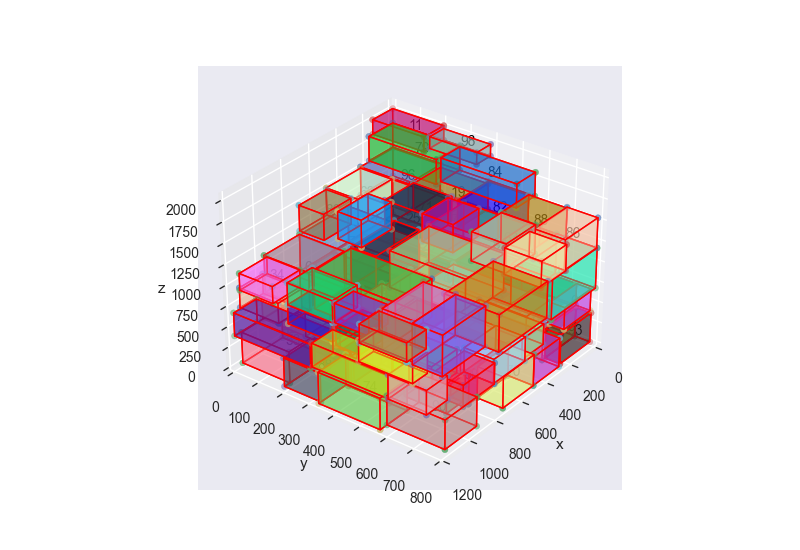

<IPython.core.display.Javascript object>


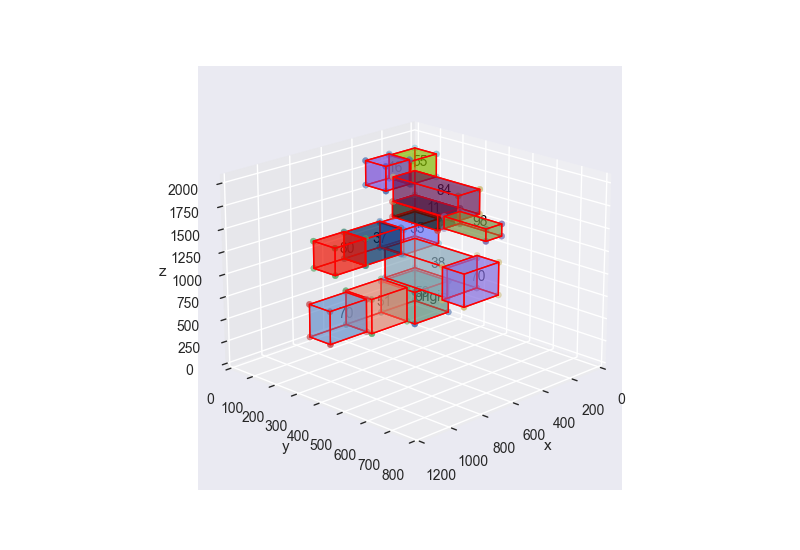

<IPython.core.display.Javascript object>


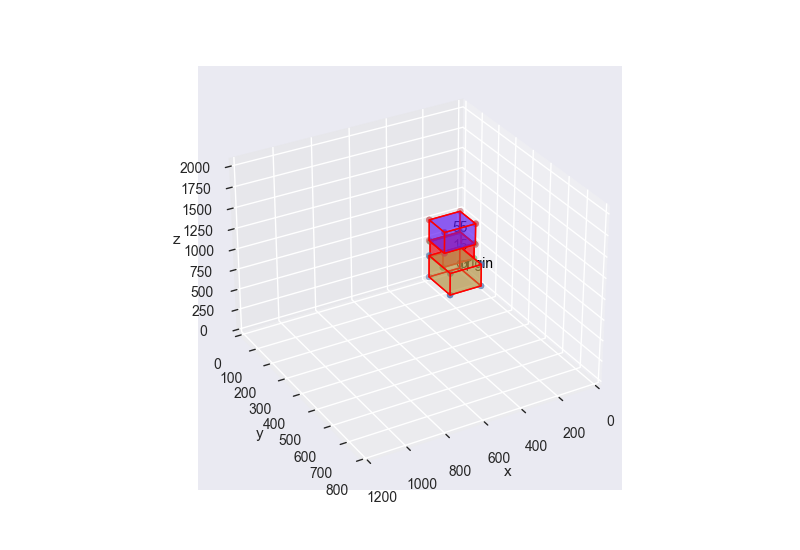

<IPython.core.display.Javascript object>

In [115]:
bin_pool.plot()
# print([b.layer_pool.get_ol() for b in bin_pool])
# print([l.superitems_pool for b in bin_pool for l in b.layer_pool])

## Column generation

- Dobbiamo passare a SP solo gli item con dual > 0?
- Dobbiamo evitare di processare layer con alpha != 1 (anche in SP no placement)?
- RMP lavora su tutti i layer, solo su quelli nuovi o su una parte?

In [64]:
order.iloc[[10, 17, 21, 46]]

,id,width,depth,height,weight,volume
10,870910,307,167,422,2,21635518
17,65725,324,98,472,2,14986944
21,905778,317,110,484,2,16877080
46,251995,307,187,387,39,22217283


<IPython.core.display.Javascript object>

In [70]:
bins_lbs = []
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for i, spool in enumerate([height_groups[101]]):
    print(f"Height group {i + 1}/{len(height_groups)}")
    print(spool)
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS, add_single=False)
    print(layer_pool)
    layer_pool, bins_lb = cg.column_generation(
        layer_pool,
        config.PALLET_DIMS,
        max_iter=100,
        max_stag_iters=5,
        tlim=None,
        use_maxrect=True,
    )
    final_layer_pool.extend(layer_pool)
    bins_lbs.append(bins_lb)

final_layer_pool.to_dataframe()

  5%|▌         | 5/100 [00:00<00:00, 246.50it/s]

Height group 1/103
SuperitemPool(superitems=[Superitem(ids=[10, 17, 21, 46], width=324, depth=187, height=1765, weight=45, volume=75716825, coords={10: Coordinate(x=8, y=10, z=0), 46: Coordinate(x=8, y=0, z=422), 21: Coordinate(x=3, y=38, z=809), 17: Coordinate(x=0, y=44, z=1293)})])
LayerPool(layers=[Layer(height=1765, ids=[10, 17, 21, 46])])
Solving RMP...
Duals: [1765.   -0.   -0.   -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 1766.0
Reduced cost: -0.0016987542469451
Solving RMP...
Duals: [  -0.   -0.   -0. 1765.]
Alpha: [1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 1766.0
Reduced cost: -0.0016987542469451
Solving RMP...
Duals: [  -0.   -0.   -0. 1765.]
Alpha: [1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 1766.0
Reduced cost: -0.0016987542469451
Solving RMP...
Duals: [  -0.   -0.   -0. 1765.]
Alpha: [1

,item,x,y,z,width,depth,height,layer
0,10,8,10,0,307,167,422,0
1,46,8,0,422,307,187,387,0
2,21,3,38,809,317,110,484,0
3,17,0,44,1293,324,98,472,0
4,10,8,10,0,307,167,422,1
5,46,8,0,422,307,187,387,1
6,21,3,38,809,317,110,484,1
7,17,0,44,1293,324,98,472,1
8,10,8,10,0,307,167,422,2
9,46,8,0,422,307,187,387,2


<IPython.core.display.Javascript object>

In [15]:
final_layer_pool = final_layer_pool.select_layers(
    config.PALLET_WIDTH, config.PALLET_DEPTH, min_density=0.0, max_coverage=3
)

<IPython.core.display.Javascript object>

In [16]:
final_layer_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer
0,20,0,0,0,232,494,441,0
1,56,0,494,0,350,287,441,0
2,21,232,0,0,343,263,411,0
3,39,232,263,0,340,192,413,0
4,51,350,455,0,300,291,444,0
...,...,...,...,...,...,...,...,...
72,36,193,119,0,243,102,406,5
73,66,226,0,0,242,109,289,6
74,68,468,0,0,240,97,304,6
75,70,242,0,0,234,112,251,7


<IPython.core.display.Javascript object>

In [17]:
np.floor(np.mean(bins_lbs) / config.PALLET_HEIGHT)

0.0

<IPython.core.display.Javascript object>

In [18]:
bin_pool = pack.BinPool(final_layer_pool, config.PALLET_DIMS)
bin_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer,bin
0,20,0,0,0,232,494,441,0,0
1,56,0,494,0,350,287,441,0,0
2,21,232,0,0,343,263,411,0,0
3,39,232,263,0,340,192,413,0,0
4,51,350,455,0,300,291,444,0,0
...,...,...,...,...,...,...,...,...,...
1,36,193,119,0,243,102,406,0,1
2,66,226,0,417,242,109,289,1,1
3,68,468,0,417,240,97,304,1,1
4,70,242,0,744,234,112,251,2,1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


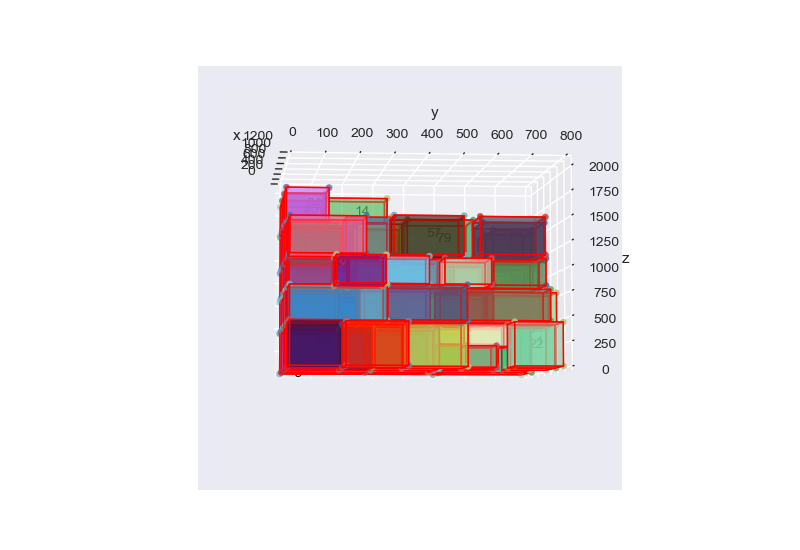

<IPython.core.display.Javascript object>


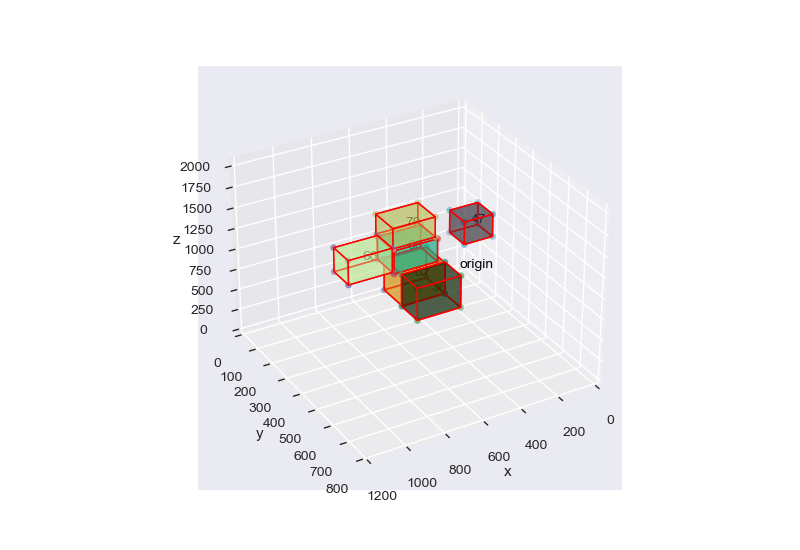

<IPython.core.display.Javascript object>

In [19]:
bin_pool.plot()

Generating vertical superitems: 100%|██████████| 27/27 [00:00<00:00, 318107.33it/s]


Height group 1/47
Height group 2/47
Height group 3/47
Height group 4/47
Height group 5/47
Height group 6/47
Height group 7/47
Height group 8/47
Height group 9/47
Height group 10/47
Height group 11/47
Height group 12/47
Height group 13/47
Height group 14/47
Height group 15/47
Height group 16/47
Height group 17/47
Height group 18/47
Height group 19/47
Height group 20/47
Height group 21/47
Height group 22/47
Height group 23/47
Height group 24/47
Height group 25/47
Height group 26/47
Height group 27/47
Height group 28/47
Height group 29/47
Height group 30/47
Height group 31/47
Height group 32/47
Height group 33/47
Height group 34/47
Height group 35/47
Height group 36/47
Height group 37/47
Height group 38/47
Height group 39/47
Height group 40/47
Height group 41/47
Height group 42/47
Height group 43/47
Height group 44/47
Height group 45/47
Height group 46/47
Height group 47/47
Items not covered: 27/98


Generating vertical superitems: 100%|██████████| 4/4 [00:00<00:00, 34663.67it/s]

Items not covered: 27/98
Items not covered: 27/98
[Superitem(ids=[55], width=219, depth=173, height=257, weight=3, volume=9736959, coords={55: Coordinate(x=0, y=0, z=0)}), Superitem(ids=[31], width=142, depth=168, height=255, weight=8, volume=6083280, coords={31: Coordinate(x=0, y=0, z=0)}), Superitem(ids=[64], width=179, depth=131, height=252, weight=2, volume=5909148, coords={64: Coordinate(x=0, y=0, z=0)}), Superitem(ids=[18], width=191, depth=80, height=250, weight=9, volume=3820000, coords={18: Coordinate(x=0, y=0, z=0)}), Superitem(ids=[70], width=203, depth=258, height=237, weight=28, volume=12412638, coords={70: Coordinate(x=0, y=0, z=0)}), Superitem(ids=[32], width=190, depth=304, height=233, weight=11, volume=13458080, coords={32: Coordinate(x=0, y=0, z=0)}), Superitem(ids=[66], width=170, depth=288, height=230, weight=5, volume=11260800, coords={66: Coordinate(x=0, y=0, z=0)}), Superitem(ids=[59], width=206, depth=150, height=219, weight=2, volume=6767100, coords={59: Coordi

<IPython.core.display.Javascript object>


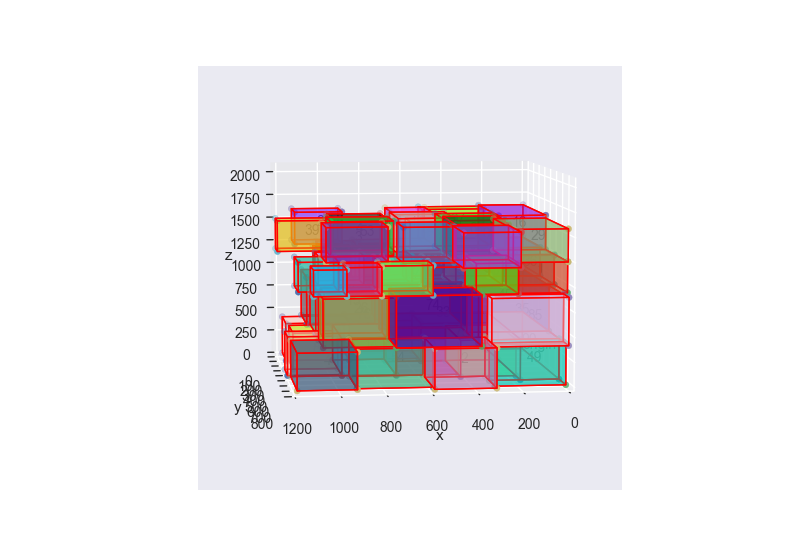

<IPython.core.display.Javascript object>


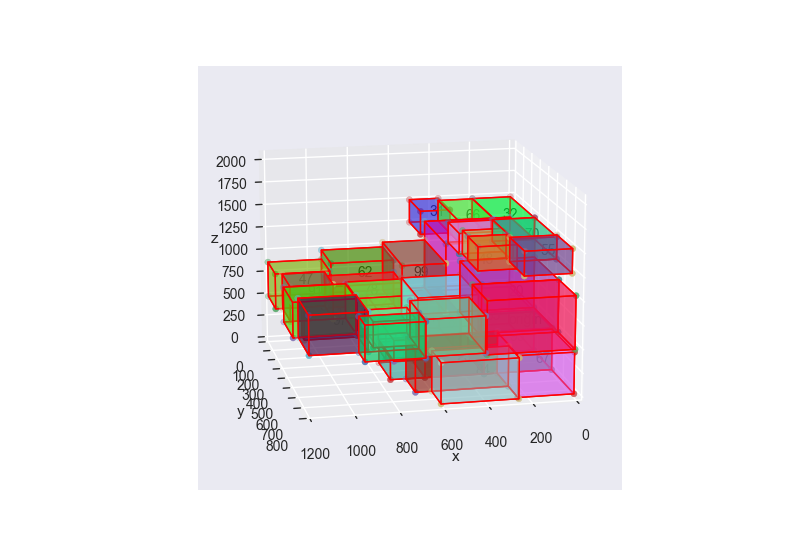

<IPython.core.display.Javascript object>

In [28]:
from src import main

mr_layer_pool, bins_lbs = main.main(order, use_cg=False)
mr_bin_pool = pack.BinPool(mr_layer_pool, config.PALLET_DIMS)
mr_bin_pool.plot()

<IPython.core.display.Javascript object>


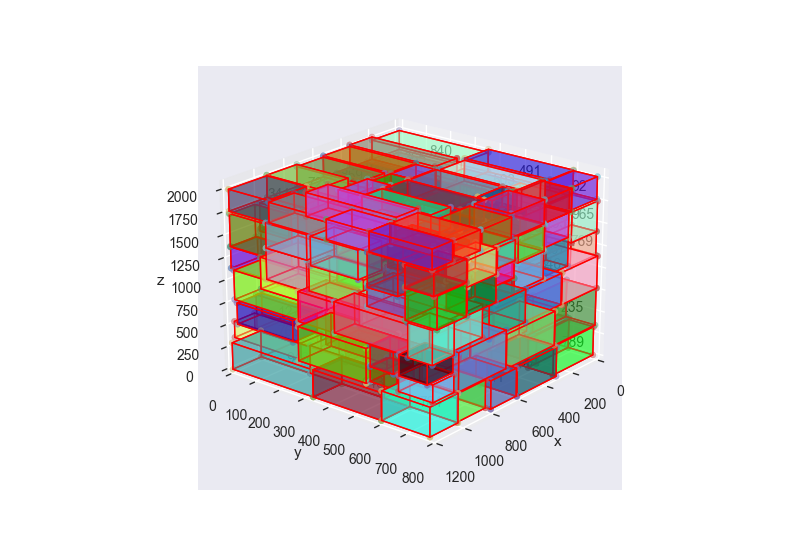

<Axes3DSubplot:xlabel='x', ylabel='y'>

<IPython.core.display.Javascript object>

In [128]:
mr_bin_pool[0].plot(config.PALLET_DIMS)

In [ ]:
from src import main

cg_layer_pool, bins_lbs = main.main(order, use_cg=True)
cg_bin_pool = pack.BinPool(cg_layer_pool, config.PALLET_DIMS)
cg_bin_pool.plot()

Generating vertical superitems: 100%|██████████| 316/316 [00:00<00:00, 846901.00it/s]


Height group 1/770
Iteration 1/100
Solving RMP...
Duals: [195.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.]
RMP time: 0.026
Alpha: [1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 229.0
SP no placement time: 0.044
Reduced cost: -30.864628820960277
Iteration 2/100
Solving RMP...
Duals: [ -0. 195.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.]
RMP time: 0.054
Alpha: [1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 229.0
SP no placement time: 0.036
Reduced cost: -4.89956331877689
Iteration 3/100
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 209.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0. 205.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
RMP time: 0.259
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 258.0
SP no placement time: 0.213
Reduced cost: -214.29069767441882
Iteration 4/100
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0. 209.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 205.  -0.  -0.]
RMP time: 0.319
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 258.0
SP no placement time: 0.106
Reduced cost: -214.2906976744188
Ite

SP no placement time: 0.298
Reduced cost: -456.33221476510045
Iteration 2/100
Solving RMP...
Duals: [ -0.  -0. 221.  -0.  -0.  -0.  -0.  -0.  -0. 221. 220.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
RMP time: 0.565
Alpha: [1.0, 1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 298.0
SP no placement time: 0.285
Reduced cost: -454.83557046979837
Iteration 3/100
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 220. 221.  -0. 221.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 220.  -0.  -0. 223. 224.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
RMP time: 0.827
Alpha: [1.0, 1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 302.0
SP no placement time: 0.3
Reduced cost: -460.07947019867913
Iteration 4/100
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 220.  -0.  -0.  -0.  -0.
  -0.  -0.  -0. 223. 224.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  

SP no placement time: 0.39
Reduced cost: -474.3354430379738
Iteration 4/100
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 227.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 227.  -0.  -0. 227.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
RMP time: 1.209
Alpha: [1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0
SP no placement time: 0.37
Reduced cost: -471.3354430379736
Iteration 5/100
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 227.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 227.
  -0.  -0. 227.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  

Duals: [ -0. 229.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0. 229.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0. 229.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
RMP time: 1.26
Alpha: [1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 321.0
SP no placement time: 0.391
Reduced cost: -477.30841121495587
Iteration 5/100
Solving RMP...
Duals: [ -0. 229.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 229.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0. 229.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 

Duals: [ -0. 230.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0. 231. 231.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
RMP time: 1.332
Alpha: [1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 323.0
SP no placement time: 0.388
Reduced cost: -479.6532507739901
Iteration 5/100
Solving RMP...
Duals: [ -0. 230.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 231.  -0.  -0.  -0.  -0.
  -0.  -0.  -0. 231.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 

Duals: [ -0. 239.  -0. 239.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 239.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0. 238.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
RMP time: 2.089
Alpha: [1.0, 1.0, 1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 357.0
SP no placement time: 0.641
Reduced cost: -733.7507002801062
Iteration 4/100
Solving RMP...
Duals: [ -0. 239.  -0.  -0.  -0.  -0. 239.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 239.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 

## Todo 

### Problemi in Input al modello:
- [ ] Correggere gestione superitem in Heigth groups
    - Problema riguardo stesso Item nello stesso Layer dovuto a superitem Horizontal nei 2 assi -> (Messo in pausa, per ora risolto usando solo Vertical e Single superitems)
    - Suddividere gruppi in piu gruppi 
        - Solo fra superitem con > 1 item e superitem con = 1 item
- [x] Eliminare gruppi con 1 solo item e gruppi con densita minore di 0.5
- [x] Creare Vertical Superitems consistenti alla loro dimensione principale (Da rivedere in caso di aggiunta rotazione, come tutto...)
- [x] Corretto calcolo volume Superitems e aggiunto enclosing_volume per Vertical Superitems
- [ ] Rivedere lower bound martello (L1 viene 0) (L0 corretto) (L2 troppo lento)

### Problemi interni al modello:
- [x] Aggiunto reward in pricing_no_placement per incetivare la costruzione di layer più densi -> Con più item, quindi anche di item con Dual[i]==0, formula di reward con upper_bound = min(dual[i] !=0)
- [x] Modificato pricing placement (v2) per piazzare tutti gli item selezionati se possibile -> Molto lento con 13 item muore ma corretto rispetto a v1 che tendeva per costruzione a non piazzare tutta la sottoparte selezionata
- [x] Aggiunto maxrect placement per i nuovi layer del column generation

    
### Problemi in Output al modello:
- [ ] Aggiungere gestione Weigth a quella della Densità con qualche priorità e spiegazione annessa
- [x] Aggiungere gestione coordinate corretta per i Vertical Superitems, centrare gli oggetti nello spazio occupato
- [x] Controllare select_layer e aggiungere flag per utilizzare solo subset di sottoprocess per testing
- [ ] Sostituire item rimossi in fase di select_layers con altri item non piazzati, usando maxrects
    - [x] per ora: rearrange con maxrects e re-iterazione di tutto il processo con gli item non piazzati
- [ ] Gestione Item rimanenti
    1. Piazzare gli ultimi item con algoritmo s-shape
    2. Provare a suddividere lo spazio rimanente in alto anche di layer incompleti in "Sotto pallet" ed usare maxrect su quelli (Magari funziona meglio)
- [ ] Gestione spaziatura 
    - Spaziatura intra-layer spiegata nel paper?
        1. 2 modelli di linear programming -> Spaziatura mediante modelli per width and depth dimensions
        2. Soluzione di spostamento monodirezionale iterativa dei blocchi di un layer (Da pensare per bene come alternativa a 1)
    - Spaziatura inter-layer in altezza
         1. Controllare spazi vuoti anche in altezza al termine di tutto usando una delle 2 tecnice sopradescritte
         
### Aggiunte eventuali
- [ ] Gestione rotazione
- [ ] Oggetti fragili -> Peso + attributi particolari


## TODO tomorrow
- Perche 98 items invece di 100?
- Finire s-shaped
- Solver e search strategy per column generation
- Rivedere lower bound
- Spaziatura